In [1]:
#import pip

In [2]:
# pip.main(["install", "openpyxl"])
#pip.main(["install","scikit-learn.linear_model"])

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
#path = Path.cwd().joinpath("Raw_sensing_data","CO","Cu-COF-DC-8","N2_dry").rglob("*.xlsx")

#for i in path:
#    print(i)

In [5]:
def read_data(cof, gas, carrier, ppm):

    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data",gas,cof,carrier,).rglob("*.xlsx")
    #print(path)
    # some folders contain multiple excel files, so append all to a list
    files = []
    for file in path:
        files.append(file)
    #print(files)
    # extract data from Excel files in list
    dfs = []
    for p in files:
        df = pd.read_excel(p,header=6,names=['time','GB1 DeltaG/G0','GB2 DeltaG/G0','GB3 DeltaG/G0','GB4 DeltaG/G0'],usecols="B,D,H,L,P",sheet_name=str(ppm) +' ppm')

        # exposure time begins at 750s
        # exposure time ends 2580s later (3330s)
        df_chopped = df.iloc[1499:6660]
        
        
        dfs.append(df_chopped)
        
        
    return dfs
# returns pandas data frame with this data. two columns: time, DeltaG/G0

In [6]:
#print(read_data("Cu-COF-DC-8","CO","N2_dry",80))

data = read_data("Cu-COF-DC-8","H2S","air_humid",80)

In [7]:
print(data)

[        time  GB1 DeltaG/G0  GB2 DeltaG/G0  GB3 DeltaG/G0  GB4 DeltaG/G0
1499   750.0       0.000000      -0.064974       0.140033       1.543782
1500   750.5       0.000000       0.000000       0.419539       0.849203
1501   751.0      -0.217382      -0.043201       0.489331       0.154502
1502   751.5       0.000000       0.237430       0.279730      -0.231444
1503   752.0      -0.217382       0.129602       0.140033       0.077066
...      ...            ...            ...            ...            ...
6655  3328.0      89.236542      99.015552      98.150651      99.165959
6656  3328.5      89.247393      99.019223      98.145059      99.169048
6657  3329.0      89.253904      99.017495      98.149947      99.167502
6658  3329.5      89.228954      99.022464      98.147151      99.163645
6659  3330.0      89.224613      99.023543      98.147151      99.162873

[5161 rows x 5 columns]]


In [8]:
# partition data into K sec windows in the first N sec 
# after substance introduction (750 sec)

K = 40
N = 400
n_partitions = int(N/K)

dfs = []
for i in range(n_partitions):
    dfs.append(data[0].iloc[i*K:(i+1)*K])

#print(dfs)
#print(dfs[1]['time'])

X = dfs[3].loc[:,"time"].to_numpy().reshape(-1,1)
Y = dfs[3].loc[:,"GB3 DeltaG/G0"].to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X,Y)

Regression coefficients:  [[0.93672504]]
Mean squared error  0.095172265486779


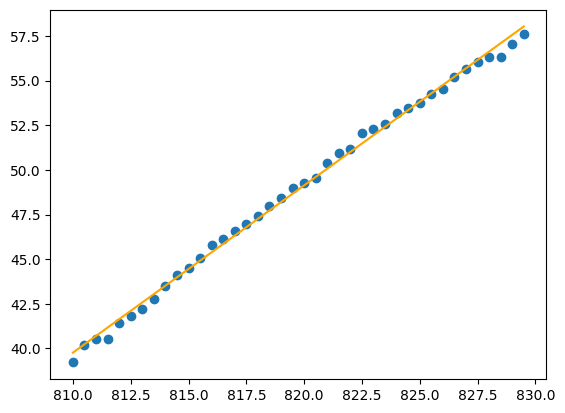

In [9]:
y_fit = reg.predict(X)


print("Regression coefficients: ",reg.coef_)
print("Mean squared error ", mean_squared_error(Y,y_fit))



plt.scatter(X,Y)
plt.plot(X,y_fit,color="orange")

plt.show()


In [10]:
# worse way to get initial slope
"""
print(data[0].loc[1497:4000])
axes = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,900),ylim=(-100,100))


init_t = 1497
init_t_end = 1570
per = 10
slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]
#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5

print(slopes)
maxslope = slopes.max()
maxloc = slopes.idxmax()
print(maxslope,maxloc)
print(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])

x = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]
y = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]

axes.plot(x,y,'orange')

axes2 = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,829.5),ylim=(-25,25))
axes2.plot(x,y,'orange') """

'\nprint(data[0].loc[1497:4000])\naxes = data[0].plot(x=\'time\',y=\'DeltaG/G0\',xlim=(749.5,900),ylim=(-100,100))\n\n\ninit_t = 1497\ninit_t_end = 1570\nper = 10\nslopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]\n#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5\n\nprint(slopes)\nmaxslope = slopes.max()\nmaxloc = slopes.idxmax()\nprint(maxslope,maxloc)\nprint(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])\n\nx = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]\ny = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]\n\naxes.plot(x,y,\'orange\')\n\naxes2 = data[0].plot(x=\'time\',y=\'DeltaG/G0\',xlim=(749.5,829.5),ylim=(-25,25))\naxes2.plot(x,y,\'orange\') '

In [11]:
# function to do linear regression on a single partition of data
    # input: partition of time & each DeltaG/G0, j := which DeltaG/G0 column (1,2,3, or 4) 
    # output: linear regression coefficients and mean squared errors
def lin_reg(df,j):
    X = df.loc[:,"time"].to_numpy().reshape(-1,1)
    Y = df.loc[:,'GB'+str(j)+" DeltaG/G0"].to_numpy().reshape(-1,1)
    reg = LinearRegression().fit(X,Y)
    y_fit = reg.predict(X)
    mse = mean_squared_error(Y,y_fit)

    coef = reg.coef_.tolist().pop().pop()

    #print("coef from lin_reg function: ",coef)

    return [coef,mse,X,Y,y_fit]

In [12]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm

        self.data = read_data(cof,gas,carrier_gas,ppm)
        
    # read in the data, do processing to get the features.
    # store data here too for viz 

    # Define function to estimate initial slope of data
    # partition_size := size of the time window for partitions (ex: 30sec)
    # total_time_window := the total time after introduction of substance
    # considered to compute intial slope (ex: 1000s)
    # k := which element of the self.data, default k=0
    # mse_bound := bound on acceptable mean squared error for initial slope linear regression
    def compute_initial_slope(self, partition_size, total_time_window,k=0,mse_bound=1):
        initial_slopes = []
        n_partitions = int(total_time_window/partition_size)
        partitions = []
        #partition the data
        for i in range(n_partitions):
            partitions.append(self.data[k].iloc[i*partition_size:(i+1)*partition_size])
        
        # perform linear regression on partitions and append (coefficient, MSE) pairs
        # to slopes_mse
        for j in range(1,5):
            slopes_mse = []
            for df in partitions:
                regdata = lin_reg(df,j)
                
                # condition on mean squared error: only include data if MSE is small enough
                if regdata[1] < mse_bound:
                    slopes_mse.append(regdata)

                
            if bool(slopes_mse) == 0:
                print("GB"+str(j)+"DeltaG/G0 has no initial slopes that satisfy mse bound. ")        
            # take initial slope to be the max of the linear regression slopes which satisfy the MSE condition
            #print(slopes_mse)
            slope_msedf = pd.DataFrame(slopes_mse)
            #print("slope_msedf: ", slope_msedf)
            initial_slopeloc = slope_msedf[0].idxmax()
            #print("initial_slopeloc: ",initial_slopeloc)
            initial_slope = slope_msedf[0].max()
            initial_slopes.append(initial_slope)

            #plot entire time series of exposure
            axes = self.data[k].plot(x='time',y='GB'+str(j)+' DeltaG/G0') 
            #plot initial slope on top of entire time series data
            axes.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")      
         
            #plot just the linear regression on top of partition data
            fig, ax = plt.subplots()
            scatter = ax.scatter(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[3].iloc[initial_slopeloc])
            
            ax.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")


        return initial_slopes

    def compute_saturation(self):
        n_partitions = int(2580/40)
        partitions = []
        #partition the data
        for i in range(n_partitions):
            partitions.append(self.data[k].iloc[i*40:(i+1)*40])
    
   #def compute_area(self):
   #def viz(self, save=False): # viz the data along with the response features or function u fit to it.
   #def vector_representation(self): # returns the vector characterizing the response.

In [13]:
# Test the SensorResponse class initial_slope function
test = SensorResponse("Cu-COF-DC-8","H2S","air_dry",80)


[1.9361849675693334, 1.5482583343604446, 1.2051431400306394, 1.4838288917660671]


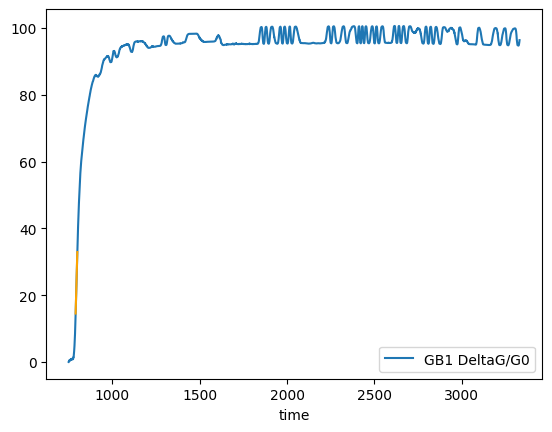

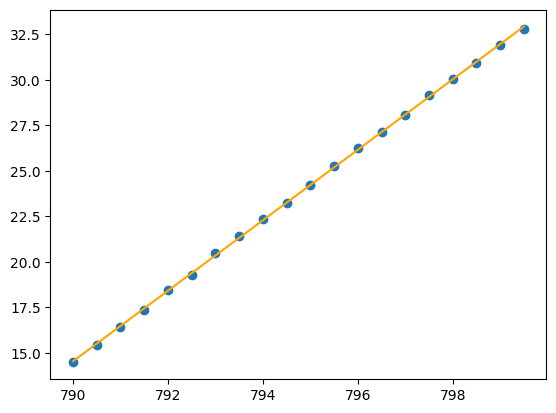

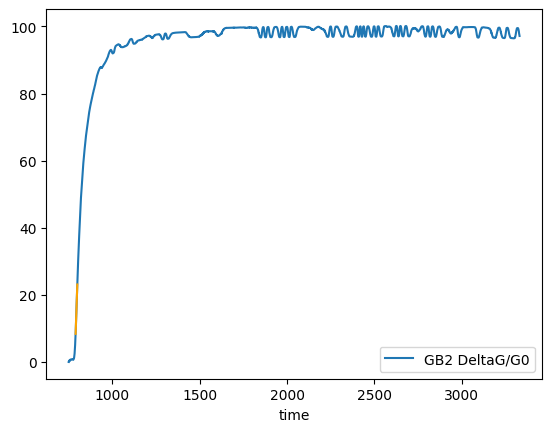

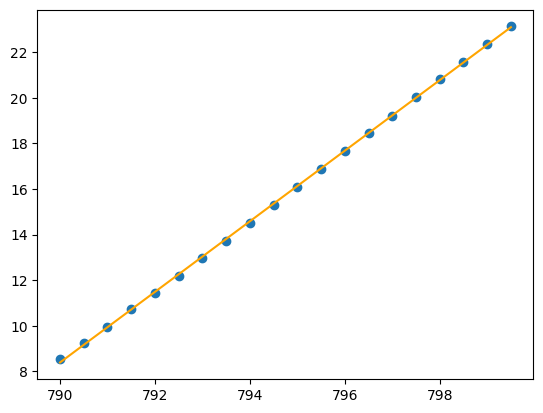

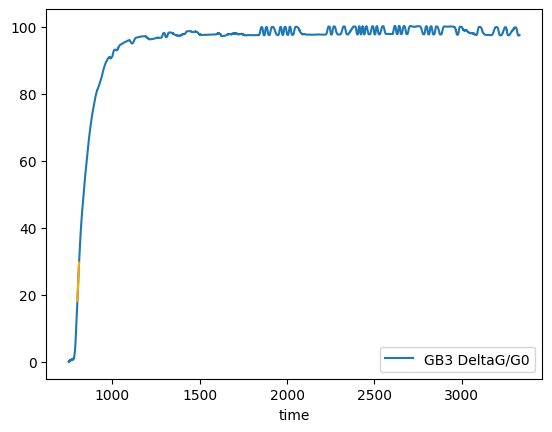

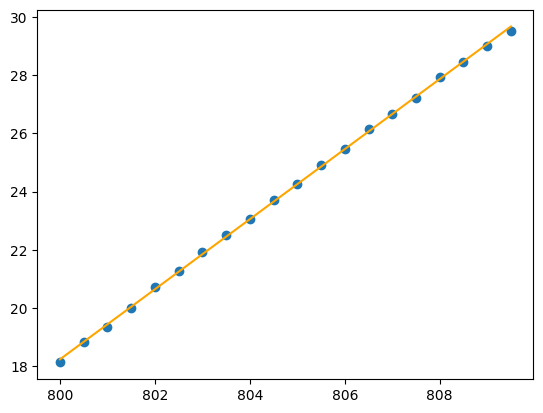

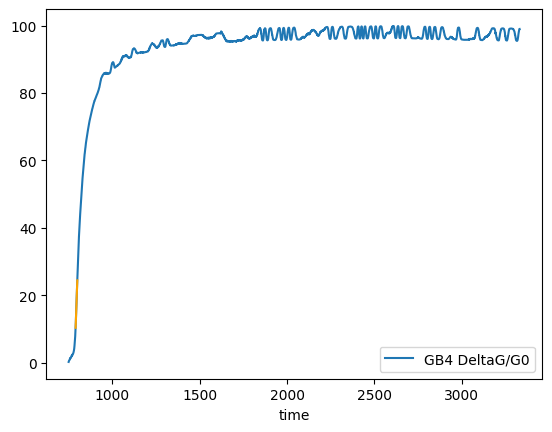

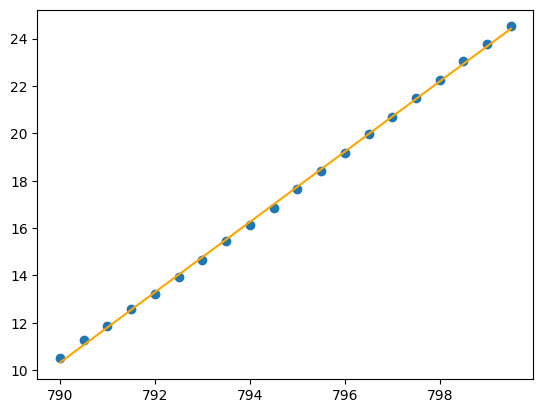

In [14]:

print(test.compute_initial_slope(20,600,0,0.1))

In [15]:
test2 = SensorResponse("Cu-COF-DC-8","NH3","air_humid",80)

[0.5513688504616934, 0.4992727619615679, 0.0, 0.0]


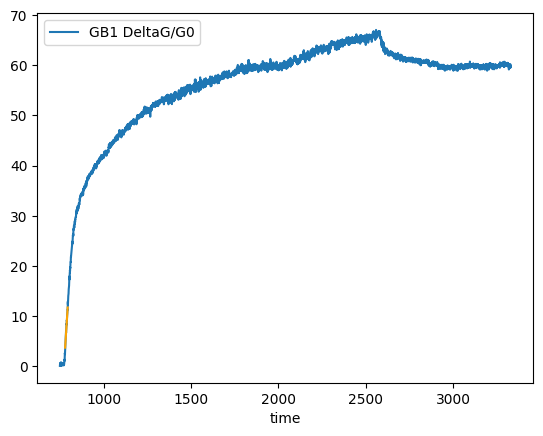

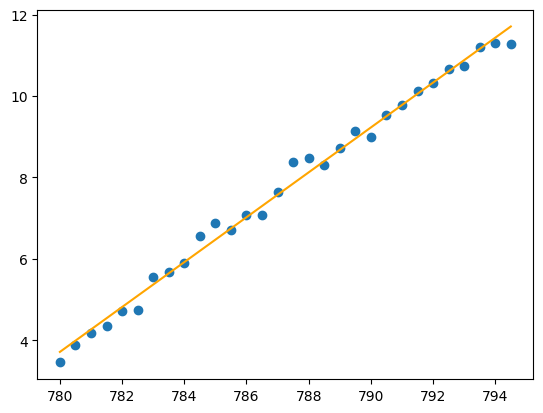

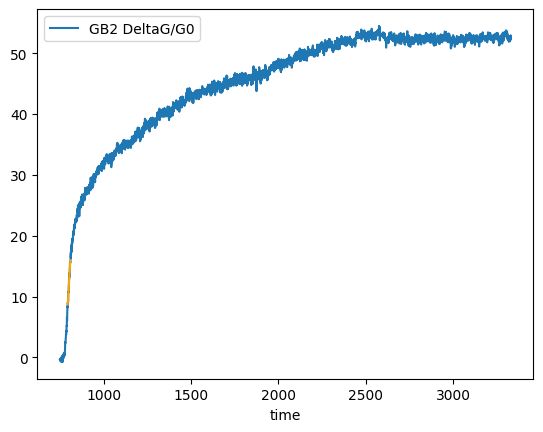

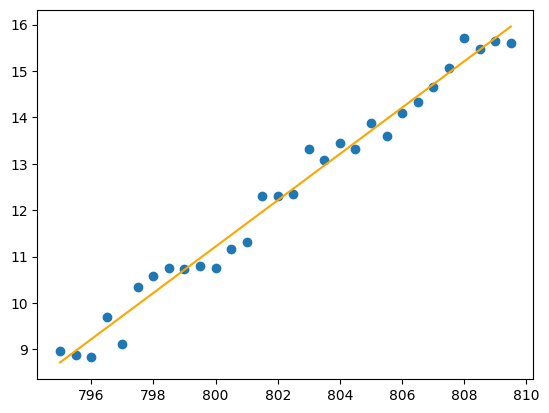

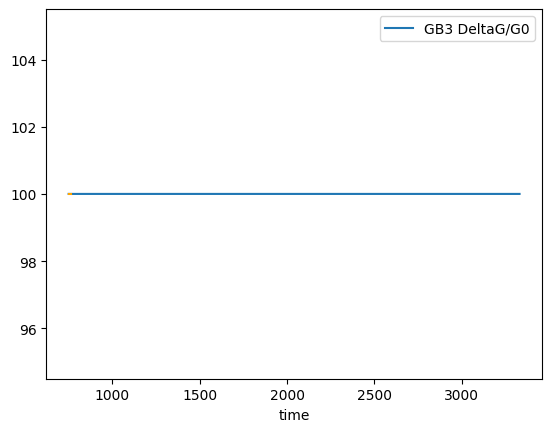

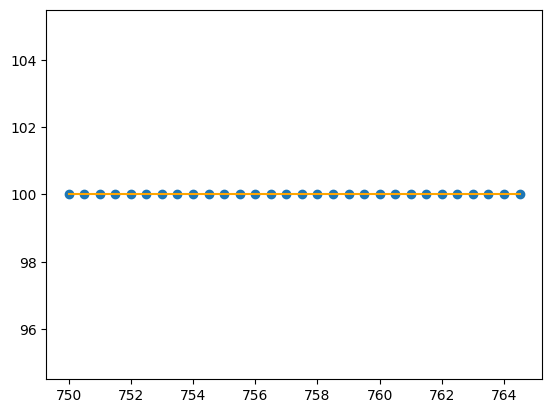

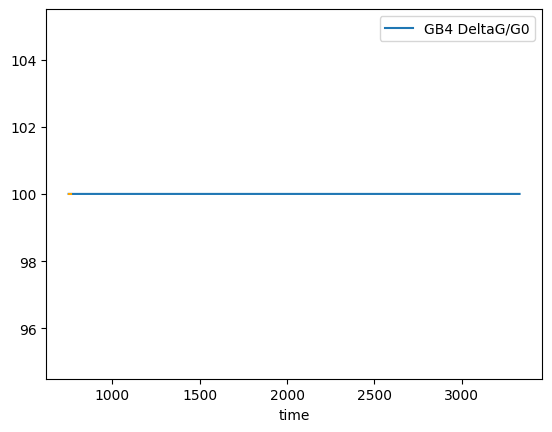

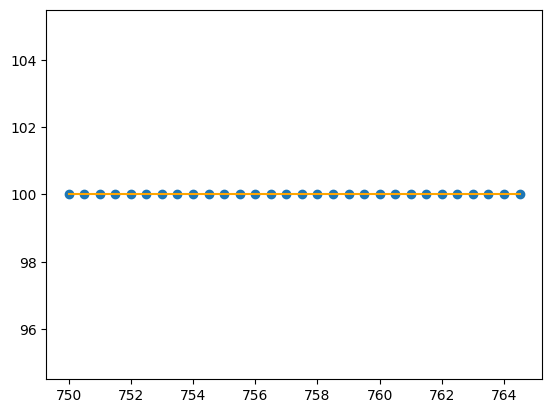

In [16]:

print(test2.compute_initial_slope(30,600,0,0.1))

# issue, getting same initial slope for NH3 and H2S